1. 加载数据
2. 搜索最佳参数
3. 可视化
4. 存标签

In [52]:
import os
import shutil
from tqdm import tqdm
import random
import math
from glob import glob

import pickle as pkl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans


In [2]:
os.getcwd()

'/data1/home/xiruiling/course/AdvanceArtificialIntelligence/AAI_Proj/script'

In [3]:
# get the current directory
# proj_root_dir = '/data1/home/xiruiling/course/AdvanceArtificialIntelligence/AAI_Proj'
proj_root_dir = os.path.abspath(os.path.join(os.getcwd(),".."))
print("proj_root_dir: ", proj_root_dir)

proj_root_dir:  /data1/home/xiruiling/course/AdvanceArtificialIntelligence/AAI_Proj


In [4]:
# load
tSNE_result_dir = os.path.join(proj_root_dir, 'state_dict', 'tSNE_3D.pkl')
with open(tSNE_result_dir, 'rb') as f:
    tSNE_result = pkl.load(f)

idx_dir = os.path.join(proj_root_dir, 'state_dict', 'fft_result_wo_simplify', 'trnIdx.pkl')
with open(idx_dir, 'rb') as f:
    Idx = pkl.load(f)

# print(tSNE_result)
print(len(Idx))

pd.reset_option('display.float_format')
tSNE_result_pd = pd.DataFrame(tSNE_result)
tSNE_result_pd


251


,0,1,2
0,2.697207e-06,2.175114e-06,-1.444606e-06
1,-1.820185e-06,1.996362e-06,-1.543234e-07
2,8.055199e-07,3.526720e-06,1.933964e-06
3,-1.747895e-06,2.983067e-06,-7.219960e-07
4,-3.069659e-06,4.365137e-06,1.587823e-06
...,...,...,...
890827,-4.436323e-07,-4.743703e-06,2.518872e-06
890828,5.872241e-06,-8.220618e-07,-6.376421e-06
890829,4.336947e-06,-1.994195e-06,-6.970361e-06
890830,4.427898e-06,-8.360230e-06,-6.005343e-06


In [89]:
# Search parameters
parameters = [16, 12, 20, 24]

# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})

best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []

# evaluation based on silhouette_score
for p in tqdm(parameter_grid):
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(tSNE_result_pd)          # fit model on wine dataset, this will find clusters based on parameter p
    with open(os.path.join('/data1/home/xiruiling/course/AdvanceArtificialIntelligence/AAI_Proj/state_dict/knn_model', 'knn_'+str(p['n_clusters'])+'_.pkl'), 'wb') as f:
        pkl.dump(kmeans_model, f)
    ss = metrics.silhouette_score(tSNE_result_pd, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores

    print('Parameter:', p, 'Score', ss)

    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p

# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

best_grid['n_clusters']

  0%|          | 0/4 [00:00<?, ?it/s]/data1/home/xiruiling/anaconda3/envs/TestEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  0%|          | 0/4 [00:18<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: "/data1/home/xiruiling/course/AdvanceArtificialIntelligence/AAI_Proj/state_dict/knn_model/knn_{'n_clusters': 16}_.pkl"

In [53]:
optimum_num_clusters = 16 #best_grid['n_clusters']
print("optimum num of clusters =", optimum_num_clusters)

optimum num of clusters = 16


In [54]:
# get the centroids
kmeans = KMeans(n_clusters=16)
with open(os.path.join(proj_root_dir, 'state_dict', 'knn_model', 'knn_16_.pkl'), 'rb') as f:
    kmeans = pkl.load(f)
# kmeans.fit(tSNE_result_pd)
centroids = kmeans.cluster_centers_
centroids
# centroids_tSNE = tSNE_result_pd.transform(centroids)

array([[ 2.4249848e-06, -4.4607566e-07, -7.8214299e-07],
       [-2.0380851e-06, -1.4212702e-06, -1.4592565e-06],
       [ 2.5294294e-06, -7.7084223e-06,  1.1989130e-06],
       [ 2.5873383e-06, -1.1744415e-06,  5.1467991e-06],
       [-6.2191029e-05,  1.0971172e-05, -2.3953377e-05],
       [-4.4796939e-06, -4.6761452e-06,  3.4210852e-06],
       [ 1.7055230e-04,  1.0153509e-04,  1.5247456e-05],
       [-4.3131022e-06,  3.9995489e-06,  6.2235523e-07],
       [-1.9149875e-06,  4.9927539e-06, -4.4635162e-06],
       [ 1.8552906e-05, -7.7297746e-06, -1.4171916e-05],
       [ 3.7116817e-05, -4.9137139e-05, -4.0375394e-06],
       [ 4.9518501e-05,  1.1685178e-05, -5.3523863e-06],
       [ 7.4055822e-07, -4.6096088e-06, -5.6198073e-06],
       [ 7.7039012e-06,  3.2632433e-05, -2.6761454e-05],
       [ 1.3663808e-09,  1.9834449e-06,  1.1528126e-06],
       [ 6.4261117e-06,  8.6819255e-06,  4.1780154e-07]], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


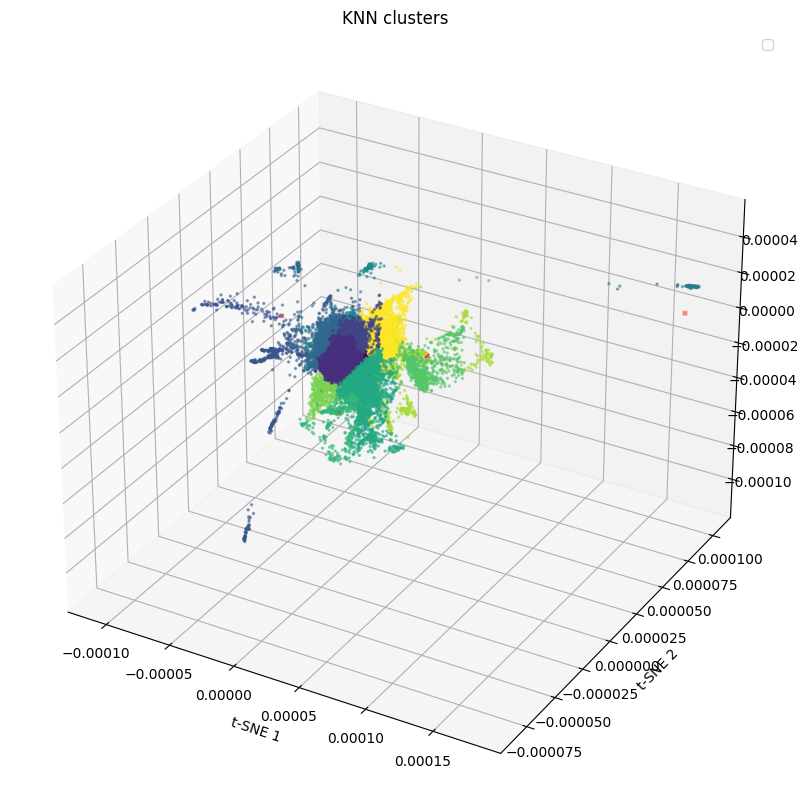

In [37]:
# Visualization

x = tSNE_result[:, 0]
y = tSNE_result[:, 1]
z = tSNE_result[:, 2]

plt.figure(figsize=(10,10))
ax = plt.axes(projection ="3d")
ax.scatter3D(x, y, z, c=kmeans.labels_, alpha=0.5, s=2)  # plot different colors per cluster
plt.scatter(centroids[:,0] , centroids[:,1] , s = 10, marker='X', color = 'red')

plt.title('KNN clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
# plt.scatter(knn_result[:, 0], knn_result[:, 1], marker='X', s=200, linewidths=1.5,
#             color='red', edgecolors="black", lw=1.5)

plt.show()

In [55]:
kmeans.labels_
np.unique(np.array(kmeans.labels_))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int32)

In [56]:
labels = kmeans.labels_

final_result = np.zeros((len(Idx)-1, 2))
for i in range(len(Idx)-1):
    final_result[i][0] = i
    majority_vote_record = np.zeros((20))
    for j in range(Idx[i], Idx[i+1]):
        majority_vote_record[labels[j]] = majority_vote_record[labels[j]] + 1
    final_result[i][1] = np.argmax(np.array(majority_vote_record))
    # print(j, "th speaker record: ", majority_vote_record)
    # print("vote: ", np.argmax(np.array(majority_vote_record)), "\n")

np.save(os.path.join(proj_root_dir, 'state_dict', 'knn_specialty'), final_result)
specialty_record = np.zeros((20))
for i in range(len(Idx)-1):
    specialty_record[int(final_result[i][1])] = specialty_record[int(final_result[i][1])] + 1

specialty_record
# final_result
# array([ 26.,  62.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   1.,   0., 0.,   1.,   0., 151.,   2.])

array([ 26.,  62.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
         0.,   1.,   0., 151.,   2.,   0.,   0.,   0.,   0.])

In [12]:
sum(specialty_record)

250.0

In [57]:
# 给第十个大类做小分类
tenth_specialty_ind_list = []
for idx, specialty in enumerate(final_result):
    if int(specialty[1]) == 14:
        tenth_specialty_ind_list.append(idx)
tenth_specialty_tSNE = []
tenth_specialty_speaker_ids_list = []
for tenth_specialty_ind in tenth_specialty_ind_list:
    start_idx = Idx[tenth_specialty_ind]
    end_idx = Idx[tenth_specialty_ind+1]
    for j in range(start_idx, end_idx):
        tenth_specialty_tSNE.append(tSNE_result[j])
        tenth_specialty_speaker_ids_list.append(tenth_specialty_ind)
tenth_specialty_tSNE

[array([ 2.6972075e-06,  2.1751137e-06, -1.4446065e-06], dtype=float32),
 array([-1.8201848e-06,  1.9963622e-06, -1.5432344e-07], dtype=float32),
 array([8.0551990e-07, 3.5267199e-06, 1.9339641e-06], dtype=float32),
 array([-1.7478945e-06,  2.9830667e-06, -7.2199600e-07], dtype=float32),
 array([-3.0696592e-06,  4.3651366e-06,  1.5878226e-06], dtype=float32),
 array([-3.2311348e-06,  3.8663329e-06, -1.4995371e-06], dtype=float32),
 array([8.911342e-07, 1.389510e-06, 6.239207e-07], dtype=float32),
 array([-3.5223777e-06,  2.2397551e-06, -5.6258233e-07], dtype=float32),
 array([ 7.1855851e-07,  1.8916005e-06, -7.7413097e-06], dtype=float32),
 array([5.9592742e-07, 3.7480406e-06, 1.9598697e-06], dtype=float32),
 array([-3.8290727e-06,  3.6191857e-06,  1.0137885e-06], dtype=float32),
 array([-7.4793741e-07,  1.1988099e-06,  7.3293938e-07], dtype=float32),
 array([7.3917149e-06, 5.5695573e-06, 1.0930185e-06], dtype=float32),
 array([ 3.5378417e-07, -3.1903310e-06,  3.0155486e-06], dtype=flo

In [58]:
kmeans_model = KMeans(n_clusters=10)
kmeans_model.fit(tenth_specialty_tSNE)          # fit model on wine dataset, this will find clusters based on parameter p
with open(os.path.join('/data1/home/xiruiling/course/AdvanceArtificialIntelligence/AAI_Proj/state_dict/knn_model', 'knn_specialty_10cluster_.pkl'), 'wb') as f:
    pkl.dump(kmeans_model, f)
np.save(os.path.join(proj_root_dir, 'state_dict', 'knn_specialty_10cluster'), tenth_specialty_speaker_ids_list)

/data1/home/xiruiling/anaconda3/envs/TestEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [59]:
# 给第十二个大类做小分类
specialty_ind_list = []
for idx, specialty in enumerate(final_result):
    if int(specialty[1]) == 1:
        specialty_ind_list.append(idx)

specialty_tSNE = []
specialty_speaker_ids_list = []
for specialty_ind in specialty_ind_list:
    start_idx = Idx[specialty_ind]
    end_idx = Idx[specialty_ind+1]
    for j in range(start_idx, end_idx):
        specialty_tSNE.append(tSNE_result[j])
        specialty_speaker_ids_list.append(specialty_ind)
specialty_tSNE

[array([8.7567867e-07, 1.0211792e-06, 5.8042019e-07], dtype=float32),
 array([1.6704839e-06, 5.9336878e-07, 7.3559490e-06], dtype=float32),
 array([-2.222851e-06, -6.918297e-06, -3.910633e-06], dtype=float32),
 array([-7.0517433e-07, -1.2388272e-06, -3.0430613e-06], dtype=float32),
 array([ 2.0195089e-06, -4.3354498e-06,  1.5517849e-06], dtype=float32),
 array([ 7.77079640e-06, -1.03376215e-05, -3.67553503e-06], dtype=float32),
 array([-4.5060974e-06, -2.5400898e-06,  1.7073888e-06], dtype=float32),
 array([ 7.6559979e-07, -4.2809080e-07, -3.5996486e-06], dtype=float32),
 array([-3.7053394e-06, -1.1361059e-06, -5.3420840e-06], dtype=float32),
 array([-7.3328067e-07, -4.9908481e-06,  1.5957596e-06], dtype=float32),
 array([-2.0945829e-06,  3.6631131e-06,  9.3664295e-07], dtype=float32),
 array([-3.7839033e-07, -1.1983499e-06,  9.0512740e-06], dtype=float32),
 array([ 5.095130e-06, -7.820362e-06,  9.946450e-06], dtype=float32),
 array([-2.1854817e-06, -4.3605423e-06,  2.5529917e-07], dty

In [60]:
kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(specialty_tSNE)          # fit model on wine dataset, this will find clusters based on parameter p
with open(os.path.join('/data1/home/xiruiling/course/AdvanceArtificialIntelligence/AAI_Proj/state_dict/knn_model', 'knn_specialty_4cluster_.pkl'), 'wb') as f:
    pkl.dump(kmeans_model, f)
np.save(os.path.join(proj_root_dir, 'state_dict', 'knn_specialty_4cluster'), specialty_speaker_ids_list)

/data1/home/xiruiling/anaconda3/envs/TestEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [61]:
specialty_ind_list = []
for idx, specialty in enumerate(final_result):
    if int(specialty[1]) !=1 and int(specialty[1]) !=14:
        specialty_ind_list.append(idx)

specialty_tSNE = []
specialty_speaker_ids_list = []
for specialty_ind in specialty_ind_list:
    start_idx = Idx[specialty_ind]
    end_idx = Idx[specialty_ind+1]
    for j in range(start_idx, end_idx):
        specialty_tSNE.append(tSNE_result[j])
        specialty_speaker_ids_list.append(specialty_ind)
specialty_tSNE

[array([ 4.676709e-06, -4.412262e-06,  1.957718e-06], dtype=float32),
 array([-3.6083945e-06,  1.8803277e-06, -2.8511636e-06], dtype=float32),
 array([-6.4084287e-07, -4.2576694e-06,  4.7510289e-06], dtype=float32),
 array([-7.5144389e-06,  5.7440957e-07, -8.1666707e-07], dtype=float32),
 array([2.5682209e-06, 3.4774601e-07, 1.9953663e-07], dtype=float32),
 array([-3.9167467e-06, -2.9572261e-06,  4.4001199e-06], dtype=float32),
 array([-8.7903442e-07,  1.3339047e-06, -2.2017464e-06], dtype=float32),
 array([-5.8588189e-06, -2.8594968e-06,  4.7806594e-07], dtype=float32),
 array([-1.18098515e-05,  2.82268638e-06,  2.05799347e-06], dtype=float32),
 array([ 3.0223389e-06, -1.8573501e-06,  3.7203713e-06], dtype=float32),
 array([-3.5816138e-06, -1.1329387e-06, -1.8226983e-06], dtype=float32),
 array([7.3069468e-06, 4.5447809e-06, 3.1849052e-06], dtype=float32),
 array([ 3.8253374e-06,  7.9384845e-06, -1.8880201e-06], dtype=float32),
 array([-4.7081767e-06, -1.1352060e-06, -2.5652622e-07], 

In [62]:
kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(specialty_tSNE)          # fit model on wine dataset, this will find clusters based on parameter p
with open(os.path.join('/data1/home/xiruiling/course/AdvanceArtificialIntelligence/AAI_Proj/state_dict/knn_model', 'knn_specialty_2cluster_.pkl'), 'wb') as f:
    pkl.dump(kmeans_model, f)
np.save(os.path.join(proj_root_dir, 'state_dict', 'knn_specialty_2cluster'), specialty_speaker_ids_list)

/data1/home/xiruiling/anaconda3/envs/TestEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
